In [ ]:
import numpy as np
import pandas as pd
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_auc_score
from sklearn.datasets import make_classification
from lightgbm import LGBMClassifier

In [ ]:
pip install optuna


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 380.1/380.1 kB 4.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.4/233.4 kB 15.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.7/78.7 kB 7.0 MB/s eta 0:00:00


In [ ]:
import optuna

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Загрузим данные

- Данные упорядочены по времени
- Задача - предсказать `target`
- Фичи - `feature_i`
- Трейн, валидация и тест уже определены (см. колонку `sample_part`)

Скачайте датасет по [ссылке](https://data.tinkoff.ru/s/WreJPgb9pJS687D). Пароль в канале курса.

In [ ]:
pip install aspose-zip


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.6/41.6 MB 19.4 MB/s eta 0:00:00


In [ ]:
df = pd.read_parquet('/content/drive/MyDrive/df.parquet.gzip')
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 500000 entries, 22620 to 310653
Columns: 235 entries, date to sample_part
dtypes: category(2), datetime64[ms](1), datetime64[us](2), float64(220), int64(9), object(1)
memory usage: 893.6+ MB


In [ ]:
df.head()

,date,month,quarter,feature_217,feature_66,feature_9,feature_193,feature_15,feature_199,feature_25,...,feature_20,feature_188,feature_71,feature_106,feature_14,feature_92,feature_179,feature_102,target,sample_part
22620,2021-01-01,2021-01-01,2021-01-01,1.180855,0.483118,13.976791,1.135021,43.271792,-46.888875,97.558366,...,23.745198,-32.001093,85.489903,1.454045,-195.725786,3.719083,1,-28.813537,0.0,train
478621,2021-01-01,2021-01-01,2021-01-01,3.427814,0.886778,27.158209,-0.378728,80.087863,-67.242703,105.803406,...,22.902111,-37.436243,71.735619,1.657242,-176.250404,3.277817,1,-45.987721,1.0,train
372254,2021-01-01,2021-01-01,2021-01-01,-38.555018,1.227175,19.893873,0.498787,98.464365,-67.402522,81.858076,...,21.848414,-51.872841,65.363236,1.626874,-178.116798,2.028950,0,-31.074122,1.0,train
2596,2021-01-01,2021-01-01,2021-01-01,-14.666558,0.753129,18.203010,-1.200014,117.331340,-25.557745,90.277266,...,26.134586,-49.703003,65.013659,1.170023,-192.232264,2.218177,1,-36.703897,0.0,train
216892,2021-01-01,2021-01-01,2021-01-01,6.734990,1.129100,11.245920,-0.108955,61.205722,-78.397406,82.637472,...,24.201039,-41.070219,69.986127,1.630795,-200.155528,3.055104,1,-44.672299,1.0,train


In [ ]:
TARGET = 'target'
N_FEATURES = 230
features = [f'feature_{i}' for i in range(N_FEATURES)]

# Первичный отбор признаков... (1 балл)

**Задание:** Сначала отсеем совсем уж мусорные признаки.

Воспользовавшись вашим кодом для вычисления `IV` из прошлой домашки, для всех **числовых** фичей вычислите `IV` на 20 бакетах. Отсейте признаки с `IV < 0.005`.

**Hint:** паркет не всегда сохраняет `dtype` колонки. Чтобы проверить признаки на "реальный" тип данных, лучше на всякий случай посмотреть на `nunique`

## Код для вычисления IV

### Шаг 0: разбиение на бакеты

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import scipy.stats as sps
from typing import Union, Tuple

In [ ]:
def calc_buckets(x : Union[np.ndarray, pd.Series], n_buckets : int) -> np.ndarray:
    """Разбивает массив значений признака x на
    n_buckets бакетов"""

    x = pd.Series(x).reset_index(drop=True)
    buckets = x.rank(method="dense", pct=True) * n_buckets
    buckets = np.ceil(buckets) - 1   # np.floor дает другой результат для 5.0, 6.0 и т.д.
    buckets = np.array(buckets, dtype=np.int16)

    return buckets

### Шаг 1: расчет WoE по бакетам

In [ ]:
from scipy.special import logit

def woe_transform(badrate : float, offset : float) -> float:
    """Считаем WoE для бакета с данным badrate и выборки
    с данным offset."""
    if badrate>=1:
      badrate=0.999
    if badrate<=0:
      badrate=0.001
    if offset<=0:
      offset=0.001
    if offset>=1:
      offset=0.999
    woe = logit(badrate) - logit(offset)
    return woe

In [ ]:
from scipy.stats import norm
def woe_ci(target : np.ndarray, buckets : np.ndarray, offset : float) -> Tuple[pd.Series]:
    """Для каждого бакета вычисляем WoE и доверительный
    интервал для него."""
    badi = np.sum(target==1)
    goodi = np.sum(target==0)
    badrate = badi/(badi+goodi)

    SE = (badrate*(1-badrate))/(badi+goodi)
    Z = norm.ppf(1 - (1-0.95)/2)
    #рассчитали бэдрейт
    badrate_lower = badrate-Z*SE
    badrate_upper = badrate+Z*SE

    # переходим от бэдрейта к woe
    woe, woe_lower, woe_upper = woe_transform(badrate,offset), woe_transform(badrate_lower,offset), woe_transform(badrate_upper,offset)

    return woe, woe_lower, woe_upper

### Шаг 2: расчет линейной интерполяции

In [ ]:
from sklearn.linear_model import LogisticRegression

def calc_line(values : np.ndarray, target : np.ndarray, mean_feature : np.ndarray, offset : float) -> np.ndarray:
    """Строим линейную интерполяцию для WoE."""
    # строим логистическую регрессию на одном признаке
    X,y = values, target
    lg = LogisticRegression()
    model = lg.fit(values.reshape(-1,1),target)
    # и считаем ее предсказания в точках – mean_feature
    proba = model.predict_proba(mean_feature.reshape(-1,1))[:,1]
    line=[]
    for i in proba:
      line.append(woe_transform(i, offset))
    return np.array(line)

### Шаг3: собираем результаты по бакетам в один словарь

In [ ]:
def calc_buckets_info(values : np.ndarray, target : np.ndarray, buckets : np.ndarray) -> dict:
    """Для каждого бакета расчитывает
     - среднее значение признака
     - линейную интерполяцию в пространстве woe
     - значение woe и доверительный интервал для него"""
    # вычисляем для кажого бакета и возвращаем массивы данных в порядке для каждого бакета,
    # например в для нулевого индекса будет всё расчитано для первого бакета)
    # Долго не мог понят, как это грамотно сделать, поэтому включил кастыли
    offset = np.sum(target==1)/(np.sum(target==1)+np.sum(target==0))
    data_f = pd.DataFrame({'values': values,'buckets':buckets,'target':target})
    mean_feature = []
    line = []
    woe = []
    woe_lower=[]
    woe_upper=[]
    data_f.head()
    for i in np.unique(buckets):
      valuei = data_f.loc[(data_f['buckets']==i)]['values'].values
      bucketsi = data_f.loc[(data_f['buckets']==i)]['buckets'].values
      targeti =  data_f.loc[(data_f['buckets']==i)]['target'].values
      mean_featurei = np.mean(valuei)
      woei, woe_loweri, woe_upperi = woe_ci(targeti, bucketsi,offset)
      mean_feature.append(mean_featurei)
      woe.append(woei)
      woe_lower.append(woe_loweri)
      woe_upper.append(woe_upperi)
    buckets_info = {
        "mean_feature" : mean_feature,
        "line"         : calc_line(values,target,np.array(mean_feature),offset),
        "woe"          : woe,
        "woe_lower"    : woe_lower,
        "woe_upper"    : woe_upper
    }

    return buckets_info

In [ ]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import r2_score
def calc_plot_title1(
        values : np.ndarray,
        target : np.ndarray,
        buckets : np.ndarray
    ) -> str:
    """Считает для признака roc auc, IV, R^2"""
    data_f = pd.DataFrame({'values': values,'buckets':buckets,'target':target})
    # формула выше
    bad = sum(target==1)
    good = sum(target==0)
    backets_u = data_f['buckets'].unique()
    IV = 0
    for i in backets_u:
      badi = sum(data_f.loc[(data_f['buckets']==i)]['target'].values ==1)
      goodi = sum(data_f.loc[(data_f['buckets']==i)]['target'].values==0)
      IV += ((badi/bad)-(goodi/good))*woe_transform(badi/(badi+goodi),bad/(bad+good))


    return IV

In [ ]:
# в этот код можно не въезжать :)
import plotly.graph_objects as go

def make_figure(buckets_info : dict, plot_title : str) -> go.Figure:
    """Строит график линейности."""
    fig = go.Figure()

    # общие настройки
    title = dict(
        text=plot_title,
        y=0.95,
        x=0.5,
        font=dict(size=12),
        xanchor="center",
        yanchor="top"
    )
    margin = go.layout.Margin(
        l=50,
        r=50,
        b=50,
        t=60
    )

    fig.add_trace(
        go.Scatter(
            x=buckets_info["mean_feature"],
            y=buckets_info["line"],
            mode='lines',
            name="interpolation_line",
            showlegend=False
        )
    )

    fig.add_trace(
        go.Scatter(
            x=buckets_info["mean_feature"],
            y=buckets_info["woe"],
            line=dict(
                color='firebrick',
                width=1,
                dash='dot'
            ),
            error_y=dict(
                type='data',
                symmetric=False,
                array=buckets_info["woe_upper"],
                arrayminus=buckets_info["woe_lower"]
            ),
            name="WoE",
            showlegend=False)
    )

    fig.update_layout(
        width=1000,
        height=450,
        xaxis_title=dict(
            text='Feature value',
            font=dict(size=12)
        ),
        yaxis_title=dict(
            text="WoE",
            font=dict(size=12)
        ),
        title=title,
        margin=margin
    )

    return fig

In [ ]:
def calc_IV(
        values : np.ndarray,
        target : np.ndarray,
        n_buckets : int
    ) -> go.Figure:
    """График линейности переменной по WoE."""
    buckets : np.ndarray = calc_buckets(values, n_buckets)
    plot_title : str = calc_plot_title1(values, target, buckets)
    return plot_title

## Отбор числовых признаков по IV

In [ ]:
features_optuna_neg = []

In [ ]:
data = df.copy()
for i in features:
  if data[i].dtype in ['float64','int64']:
    data_delet_propusk = data.dropna(subset=[i])
    if calc_IV(data_delet_propusk[i].values,data_delet_propusk[TARGET].values,20)<0.005:
      features_optuna_neg.append(i)

**Вопрос**: Почему некорректно сравнивать `IV` у категориальных и числовых фичей?

Вычислите IV для категориальных фичей на `n` бакетах, где `n = min(число категорий фичи, 20)`. Возможно, придётся перекодировать некоторые фичи (*только не OneHot-ом!*)

*Опционально*: примените также и к категориальным фичам предварительный отбор по `IV` с менее строгим порогом

In [ ]:
#потому что у категориальных фичей может сильно отличаться IV от числовых, но вклад в модель они сделают намного больший
data.dtypes[data.dtypes=='category']

feature_0      category
feature_209    category
dtype: object

In [ ]:
data['feature_0'].unique()

['c', 'd', 'b', 'a']
Categories (4, object): ['a' < 'b' < 'c' < 'd']

In [ ]:
data['feature_209'].unique()

['PRIV', 'GVM', 'UNEMP']
Categories (3, object): ['UNEMP' < 'GVM' < 'PRIV']

In [ ]:
data_delet_propusk = data.dropna(subset=['feature_209'])
calc_IV(data_delet_propusk['feature_209'].values,data_delet_propusk[TARGET].values,20)


0.02519535296049066

In [ ]:
data_delet_propusk = data.dropna(subset=['feature_0'])
calc_IV(data_delet_propusk['feature_0'].values,data_delet_propusk[TARGET].values,20)


0.0008358691357387304

Если сравнить IV у 0 и 209 признака, то можно сделать вывод, что 0 является мусорным, так как его IV намного ниже, поэтому удалим этот признак


In [ ]:
features_optuna_neg.append('feature_0')

In [ ]:
#скопируем дата
data_1 = data.copy()

# Бустинг

## Подбор гиперпараметров бустинга (2 балла)

Теперь подберем оптимальные гиперпараметры бустинга.

In [ ]:
# В переменную features_optuna положите список признаков с предыдущего шага
features_optuna = [x for x in features if x not in features_optuna_neg]

**Задание:** Заполните пропуски в коде ниже и подберите оптимальные гиперпараметры.

Для успешного решения необходимо преодолеть порог ROC-AUC `0.725` на тестовой выборке.

In [ ]:
def objective(trial):
    params = {
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.2, log=False),
        'num_leaves': trial.suggest_int('num_leaves', 100, 155),
        'min_child_samples':trial.suggest_int('min_child_samples', 120, 140),
        #####
        # your code here
        # Тут вы можете добавить любые гиперпараметры LGBMClassifier (например, что-то из того, что разбирали в лекции)
        #####
        'random_state': 42
    }

    clf = LGBMClassifier(**params)
    clf.fit(
        X=df.loc[df['sample_part'] == 'train', features_optuna],
        y=df.loc[df['sample_part'] == 'train', TARGET]
    )
    preds = clf.predict_proba(df.loc[df['sample_part'] == 'val', features_optuna])[:, 1]
    auc_valid = roc_auc_score(
        y_true=df.loc[df['sample_part'] == 'val', TARGET],
        y_score=preds
    )

    return auc_valid

In [ ]:
#study = optuna.create_study(direction='maximize')
# study.optimize(objective, n_trials=30)

In [ ]:
#print(study.best_params)

In [ ]:
best_params = {'learning_rate': 0.12, 'num_leaves': 152, 'min_child_samples': 139}

In [ ]:
clf = LGBMClassifier(**best_params)
clf.fit(
    X=df.loc[df['sample_part'] == 'train', features_optuna],
    y=df.loc[df['sample_part'] == 'train', TARGET]
)

preds_test = clf.predict_proba(df.loc[df['sample_part'] == 'test', features_optuna])[:, 1]
auc_test = roc_auc_score(
    y_true=df.loc[df['sample_part'] == 'test', TARGET],
    y_score=preds_test
)
assert auc_test > 0.725, f'Необходимое значение ROC-AUC 0.725 и выше, ваше значение: {auc_test}!'
print(auc_test)

[LightGBM] [Info] Number of positive: 177320, number of negative: 72680
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.338681 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13585
[LightGBM] [Info] Number of data points in the train set: 250000, number of used features: 61
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.709280 -> initscore=0.891890
[LightGBM] [Info] Start training from score 0.891890
0.7259690710946793


Параметры при которых ROC AUC > 0.725
{'learning_rate': 0.12, 'num_leaves': 152, 'min_child_samples': 139}


## Кривые накопления (1 балл)

**Задание:** Отрисуйте кривые накопления `ROC AUC` от `n_estimators` для бустинга с гиперпараметрами из предыдущего пункта.

**Hint:** для получения auc на каждой итерации обучения `LGBMClassifier`, можно воспользоваться параметрами `eval_set`, `eval_metric` и в методе `fit`.

In [ ]:
clf = LGBMClassifier(**{'learning_rate': 0.12, 'num_leaves': 152, 'min_child_samples': 139})
clf.fit(
    X=df.loc[df['sample_part'] == 'train', features_optuna],
    y=df.loc[df['sample_part'] == 'train', TARGET],
    eval_set = (df.loc[df['sample_part'] == 'test', features_optuna],df.loc[df['sample_part'] == 'test', TARGET]),
    eval_metric = ['auc'],
    categorical_feature=['feature_209']
)

preds_test = clf.predict_proba(df.loc[df['sample_part'] == 'test', features_optuna])[:, 1]
auc_test = roc_auc_score(
    y_true=df.loc[df['sample_part'] == 'test', TARGET],
    y_score=preds_test
)

[LightGBM] [Info] Number of positive: 177320, number of negative: 72680
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.209730 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13586
[LightGBM] [Info] Number of data points in the train set: 250000, number of used features: 61
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.709280 -> initscore=0.891890
[LightGBM] [Info] Start training from score 0.891890


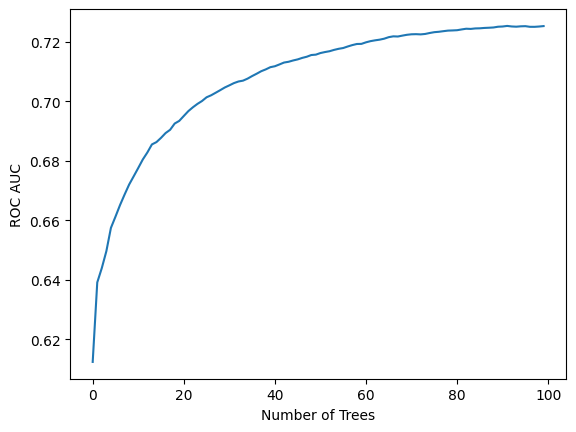

In [ ]:
aucs = clf.evals_result_['valid_0']['auc']
plt.plot([x for x in range(100)], aucs)
plt.xlabel('Number of Trees')
plt.ylabel('ROC AUC')
plt.show()

**Вопрос:** Что вы видите на полученных графиках?

Нужно ли "обрезать" количество деревьев? Ответ обоснуйте.

In [ ]:
# Как видим значение ROC AUC не уменьшается, значит число деревьев можно не уменьшать

## Важность признаков (1 балл)

**Задание:** Постойте гистограмму важности признаков по `split` и `gain` для бустинга из предыдущего пункта.

In [ ]:
clf = LGBMClassifier(**{'learning_rate': 0.12, 'num_leaves': 152, 'min_child_samples': 139,'importance_type': 'split'})
clf.fit(
    X=df.loc[df['sample_part'] == 'train', features_optuna],
    y=df.loc[df['sample_part'] == 'train', TARGET],
    categorical_feature=['feature_209']
)
split_importance = clf.feature_importances_
sort_split_importance = [[split_importance[i],features_optuna[i]] for i in range(len(features_optuna))]
sort_split_importance.sort(key = lambda x: x[0],reverse=True)

[LightGBM] [Info] Number of positive: 177320, number of negative: 72680
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.202166 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13586
[LightGBM] [Info] Number of data points in the train set: 250000, number of used features: 61
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.709280 -> initscore=0.891890
[LightGBM] [Info] Start training from score 0.891890


In [ ]:
clf = LGBMClassifier(**{'learning_rate': 0.12, 'num_leaves': 152, 'min_child_samples': 139,'importance_type': 'gain'})
clf.fit(
    X=df.loc[df['sample_part'] == 'train', features_optuna],
    y=df.loc[df['sample_part'] == 'train', TARGET],
    categorical_feature=['feature_209']
)
split_importance = clf.feature_importances_
sort_gain_importance = [[split_importance[i],features_optuna[i]] for i in range(len(features_optuna))]
sort_gain_importance.sort(key = lambda x: x[0],reverse=True)

[LightGBM] [Info] Number of positive: 177320, number of negative: 72680
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.087666 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 13586
[LightGBM] [Info] Number of data points in the train set: 250000, number of used features: 61
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.709280 -> initscore=0.891890
[LightGBM] [Info] Start training from score 0.891890


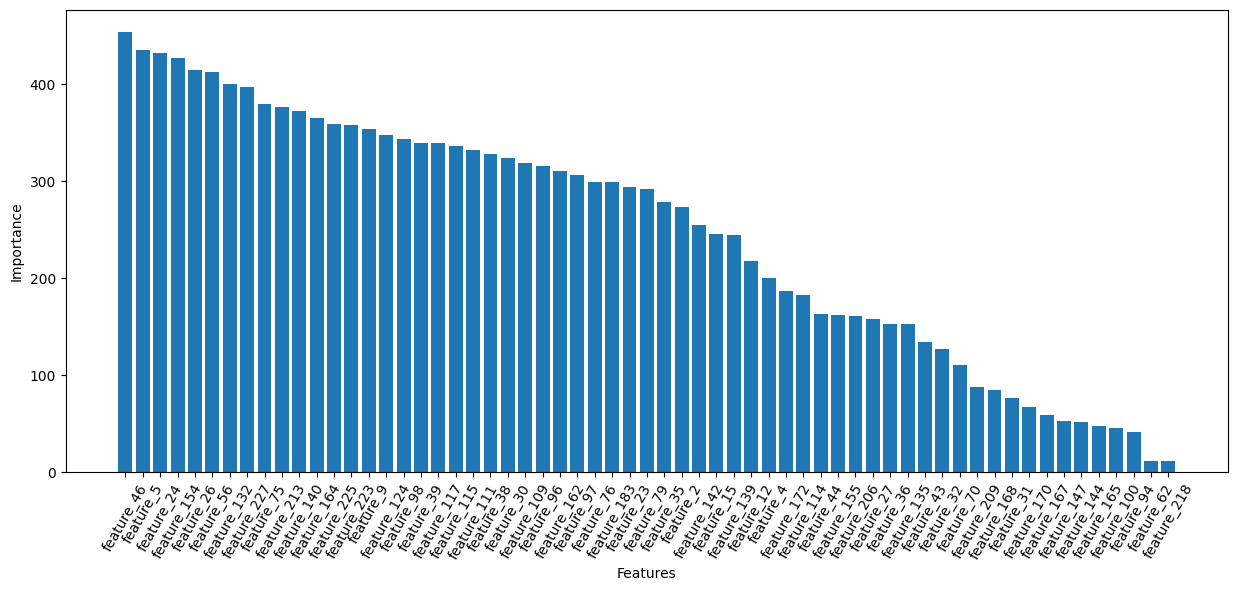

In [ ]:
plt.figure(figsize=(15, 6))
plt.bar([x[1] for x in sort_split_importance], [x[0] for x in sort_split_importance])
plt.xlabel('Features')
plt.ylabel('Importance')
plt.xticks(rotation=60)
plt.show()

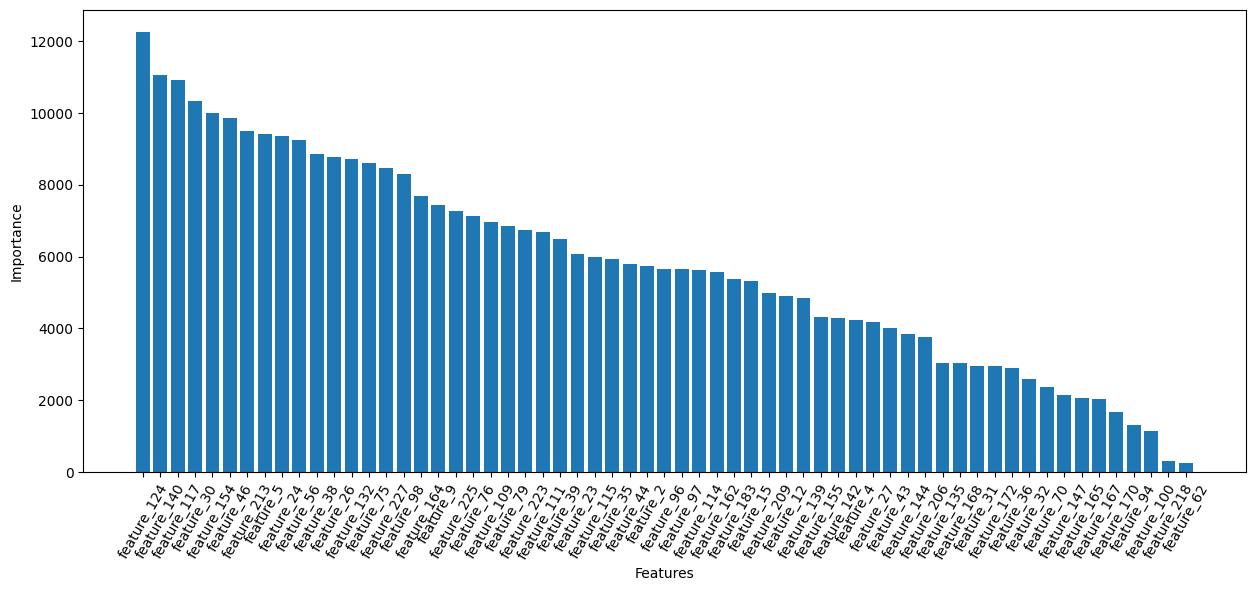

In [ ]:
plt.figure(figsize=(15, 6))
plt.bar([x[1] for x in sort_gain_importance], [x[0] for x in sort_gain_importance])
plt.xlabel('Features')
plt.ylabel('Importance')
plt.xticks(rotation=60)
plt.show()

**Вопрос:** Какие выводы можно сделать из полученных графиков?

In [ ]:
# топ признаков сильно отличается(чаще перестановками, нет такого, что признак в топе по сплиту и находистя в конце топа по гейну), но одни и те же признаки находятся в конце 'feature_218','feature_100','feature_94','feature_62'

# Логрег

## plot_metric_time (1 балл)

**Задание:** Реализуйте функцию plot_metric_time, которая будет принимать на вход четыре аргумента, а именно:
- массив значений фичи,
- массив значений таргета,
- массив времени (аггрегированного по месяцам или кварталам, то есть `month` или `quarter` в вашей задаче, по дням рисовать не надо),
- метрику, которую необходимо отрисовать (нужно реализовать функцию для двух метрик: `IV` и `roc_auc`)
- число бакетов для вычисления `IV`, если выбрана эта метрика

Можете добваить какие-то ещё аргументы, если вам нужно

Если в фиче есть пропуски, функция должна убирать строки с пропусками из рассмотрения

**Hint**: можно, конечно, реализовать эту функцию через цикл, а можно попробовать разобраться и реализовать её через пандасовские `groupby` -> `apply`, это изящнее и быстрее

In [ ]:
import plotly.graph_objects as go

In [ ]:
def plot_metric_time(
        values: pd.Series,
        target: pd.Series,
        time: pd.Series,
        metric: str = 'IV',
        n_buckets_for_IV: int = 15
) -> go.Figure:
    values_name = values.name
    time_name = time.name
    data_ter = pd.DataFrame({'values': values,'time':time,'target':target})
    data_ter = data_ter.dropna()
    time_u = time.unique()
    #уникальные значения времени
    metrics=[]
    if metric == 'IV':
        for i in time_u:
          metrics.append(calc_IV(data_ter.loc[data_ter['time']==i]['values'].values,data_ter.loc[data_ter['time']==i]['target'].values,n_buckets_for_IV))
    elif metric == 'roc_auc':
        for i in time_u:
          values_i = data_ter.loc[data_ter['time']==i]['values'].values
          target_i = data_ter.loc[data_ter['time']==i]['target'].values
          lg = LogisticRegression()
          model_i = lg.fit(values_i.reshape(-1,1),target_i)
          auc_i = roc_auc_score(target_i,model_i.predict_proba(values_i.reshape(-1,1))[:, 1])
          metrics.append(auc_i)
    else:
        raise NotImplementedError("only 'IV' and 'roc_auc' metrics are implemented")

    # your code here

    plot_title = values_name+','+metric+' in time'
    fig = go.Figure()
    fig.add_trace(
        go.Scatter(
            x= time.unique(),
            y= metrics,
            mode='markers+lines',
            name= metric
            ))
    fig.update_layout(
            title_text=plot_title,
            yaxis=dict(title=metric),
            width=1000,
            height=450,
            xaxis=dict(
                domain=[0, .95],
                showgrid=True,
                tickvals= time_u
                ),
            margin=dict(l=30, r=30, b=30, t=50),
            )
    fig.show()

    # return fig

In [ ]:
# примерно так это должно будет выглядеть
plot_metric_time(df['feature_124'], df['target'], df['quarter'],metric='roc_auc') #

**Задание:** Возьмите **топ-15** фичей получившегося бустинга по важности по `gain`. Отрисуйте для них графики стабильности по `IV` во времени и удалите из рассмотрения те признаки, качество которых деградирует

**NB!** Обращайте внимание на масштаб оси *y!* Иногда признак стабильнее, чем кажется)

Если вам это мешает, можете поменять ось *y*, чтобы она начиналась от нуля в прошлом задании.

In [ ]:
[x[1] for x in sort_gain_importance][:15]

['feature_124',
 'feature_140',
 'feature_117',
 'feature_30',
 'feature_154',
 'feature_46',
 'feature_213',
 'feature_5',
 'feature_24',
 'feature_56',
 'feature_38',
 'feature_26',
 'feature_132',
 'feature_75',
 'feature_227']

In [ ]:
top15features = [x[1] for x in sort_gain_importance][:15]
for i in top15features:
  plot_metric_time(df[i], df['target'], df['quarter'])

На этом моменте предлагаю сделать новый маленький датафрейм, чтобы не "портить" исходный

И проводить все манипуляции с фичами на нём

In [ ]:
top15features_stable = ['feature_124','feature_140','feature_117','feature_30','feature_46','feature_213','feature_5','feature_56','feature_24','feature_38','feature_26','feature_132','feature_75','feature_227']

In [ ]:
df_for_logreg = df[top15features_stable + ['date', 'month', 'quarter', 'target', 'sample_part']]

Только фича 154 значительно деградирует со временем, остальные ведут себя +- стабильно

##КОД ДЛЯ ОТРИСОВКИ WOE

In [ ]:
def calc_buckets(x : Union[np.ndarray, pd.Series], n_buckets : int) -> np.ndarray:
    """Разбивает массив значений признака x на
    n_buckets бакетов"""

    x = pd.Series(x).reset_index(drop=True)
    buckets = x.rank(method="dense", pct=True) * n_buckets
    buckets = np.ceil(buckets) - 1   # np.floor дает другой результат для 5.0, 6.0 и т.д.
    buckets = np.array(buckets, dtype=np.int16)

    return buckets

### Шаг 1: расчет WoE по бакетам

Пусть $x_i \in \{ 0, 1\}^n$

$x_i$ - это вектор, состоящий из значений таргета *в одном бакете* $i$.

Для бакета можно посчитать количество единиц $B_i$ (bads, выпавшие в дефолт) и количество нулей $G_i$ (goods).

$$
B_i = \sum_{j \in x_i} \mathbb{I} \{ j = 1\}\quad G_i = \sum_{j \in x_i} \mathbb{I} \{ j = 0\}
$$

Также число бэдов и гудов можно посчитать и **для всей выборки**:

$$
% X = x_1 \cup x_2 \ldots \cup x_n
X = \{x_1,\; x_2\; \ldots\; x_n\}
$$

$$
B = \sum_{j \in X} \mathbb{I} \{ j = 1\}\quad G = \sum_{j \in X} \mathbb{I} \{ j = 0\}
$$

Тогда WoE можно посчитать как

$$
\text{WoE}_i(x) = \ln \Big ( \frac{B_i}{G_i} \Big ) - \ln \Big ( \frac{B}{G} \Big )
$$

**Задание**

Убедиться, что

$$
\text{WoE}_i(x) = \text{logit}(b_i) - \text{logit}(b)\quad  (1)
$$

где

$$
b = \frac{B}{B + G}\quad \text{logit}(p) = \ln \Big (  \frac{p}{1 - p} \Big )
$$

В дальнейшем будем считать WoE по формуле $(1)$

In [ ]:
from scipy.special import logit

def woe_transform(badrate : float, offset : float) -> float:
    """Считаем WoE для бакета с данным badrate и выборки
    с данным offset."""
    if badrate>=1:
      badrate=0.999
    if badrate<=0:
      badrate=0.001
    if offset<=0:
      offset=0.001
    if offset>=1:
      offset=0.999
    woe = logit(badrate) - logit(offset)
    return woe

Здесь и далее предлагается протестироать получившиеся функции. Нужно проверить, что
 - функция не ложится с ошибкой
 - возвращает то, что ожидается

In [ ]:
woe_transform(1,1)

0.0

Ниже представлен шаблон функции, которая будет считать доверительный интервал к нашим вычислениям. Можно воспользоваться любым способом, который вам больше нравится. Для идей можно посмотреть различные способы подсчета доверительного интервала [здесь](https://en.wikipedia.org/wiki/Binomial_proportion_confidence_interval).

**P. S.**
Для того, чтобы построить доверительный интервал к $WoE$, можно сначала построить его для величины  $b_i = \frac{B_i}{B_i+G_i}$, а потом применить ```woe_transform```. В свою очередь величина $b_i$ является параметром распределения Бернулли, который мы можем оценить классическими методами (см. ссылку выше)

In [ ]:
from scipy.stats import norm
def woe_ci(target : np.ndarray, buckets : np.ndarray, offset : float) -> Tuple[pd.Series]:
    """Для каждого бакета вычисляем WoE и доверительный
    интервал для него."""
    badi = np.sum(target==1)
    goodi = np.sum(target==0)
    badrate = badi/(badi+goodi)

    SE = (badrate*(1-badrate))/(badi+goodi)
    Z = norm.ppf(1 - (1-0.95)/2)
    #рассчитали бэдрейт
    badrate_lower = badrate-Z*SE
    badrate_upper = badrate+Z*SE

    # переходим от бэдрейта к woe
    woe, woe_lower, woe_upper = woe_transform(badrate,offset), woe_transform(badrate_lower,offset), woe_transform(badrate_upper,offset)

    return woe, woe_lower, woe_upper

### Шаг 2: расчет линейной интерполяции

In [ ]:
from sklearn.linear_model import LogisticRegression

def calc_line(values : np.ndarray, target : np.ndarray, mean_feature : np.ndarray, offset : float) -> np.ndarray:
    """Строим линейную интерполяцию для WoE."""
    # строим логистическую регрессию на одном признаке
    X,y = values, target
    lg = LogisticRegression()
    model = lg.fit(values.reshape(-1,1),target)
    # и считаем ее предсказания в точках – mean_feature
    proba = model.predict_proba(mean_feature.reshape(-1,1))[:,1]
    line=[]
    for i in proba:
      line.append(woe_transform(i, offset))
    return np.array(line)

### Шаг3: собираем результаты по бакетам в один словарь

In [ ]:
def calc_buckets_info(values : np.ndarray, target : np.ndarray, buckets : np.ndarray) -> dict:
    """Для каждого бакета расчитывает
     - среднее значение признака
     - линейную интерполяцию в пространстве woe
     - значение woe и доверительный интервал для него"""
    # вычисляем для кажого бакета и возвращаем массивы данных в порядке для каждого бакета,
    # например в для нулевого индекса будет всё расчитано для первого бакета)
    # Долго не мог понят, как это грамотно сделать, поэтому включил кастыли
    offset = np.sum(target==1)/(np.sum(target==1)+np.sum(target==0))
    data_f = pd.DataFrame({'values': values,'buckets':buckets,'target':target})
    mean_feature = []
    line = []
    woe = []
    woe_lower=[]
    woe_upper=[]
    data_f.head()
    for i in np.unique(buckets):
      valuei = data_f.loc[(data_f['buckets']==i)]['values'].values
      bucketsi = data_f.loc[(data_f['buckets']==i)]['buckets'].values
      targeti =  data_f.loc[(data_f['buckets']==i)]['target'].values
      mean_featurei = np.mean(valuei)
      woei, woe_loweri, woe_upperi = woe_ci(targeti, bucketsi,offset)
      mean_feature.append(mean_featurei)
      woe.append(woei)
      woe_lower.append(woe_loweri)
      woe_upper.append(woe_upperi)
    buckets_info = {
        "mean_feature" : mean_feature,
        "line"         : calc_line(values,target,np.array(mean_feature),offset),
        "woe"          : woe,
        "woe_lower"    : woe_lower,
        "woe_upper"    : woe_upper
    }

    return buckets_info

In [ ]:
# протестируйте calc_buckets_info

### Шаг 4: считаем метрики признака

Рассчитаем также несколько метрик, чтобы судить о качестве признака не только по картинкам.

Приведем формулу для IV:

$$
\text{IV}(x) = \sum_{i = 1}^{n}\Big ( \frac{B_i}{B} - \frac{G_i}{G} \Big ) \times \text{WoE}_i
$$

**Вопрос:** зачем считать ранжирующую силу признака двумя способами? Какую дополнительную информацию может дать IV относительно roc auc?

In [ ]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import r2_score
def calc_plot_title(
        values : np.ndarray,
        target : np.ndarray,
        buckets : np.ndarray
    ) -> str:
    """Считает для признака roc auc, IV, R^2"""
    lg = LogisticRegression()
    model = lg.fit(values.reshape(-1,1),target)
    auc = roc_auc_score(target,model.predict_proba(values.reshape(-1,1))[:, 1])
    data_f = pd.DataFrame({'values': values,'buckets':buckets,'target':target})
    # формула выше
    bad = sum(target==1)
    good = sum(target==0)
    backets_u = data_f['buckets'].unique()
    IV = 0
    for i in backets_u:
      badi = sum(data_f.loc[(data_f['buckets']==i)]['target'].values ==1)
      goodi = sum(data_f.loc[(data_f['buckets']==i)]['target'].values==0)
      IV += ((badi/bad)-(goodi/good))*woe_transform(badi/(badi+goodi),bad/(bad+good))

    # Взвешенный R^2
    # X - среднее в бакете, Y - woe в бакете, вес – число наблюдений в бакете
    X=[]
    Y=[]
    weight=[]
    for i in backets_u:
      X.append(data_f.loc[(data_f['buckets']==i)]['values'].mean())
      badi = sum(data_f.loc[(data_f['buckets']==i)]['target'].values ==1)
      goodi = sum(data_f.loc[(data_f['buckets']==i)]['target'].values==0)
      Y.append(woe_transform(badi/(badi+goodi),bad/(bad+good)))
      weight.append(sum(buckets==i))

    R_sqr = r2_score(calc_line(values,target,np.array(X),bad/(bad+good)),Y, sample_weight=weight)

    plot_title = (
        f"AUC = {auc:.3f} "
        f"IV = {IV:.3f} "
        f"R_sqr = {R_sqr:.3f} "
    )

    return plot_title

In [ ]:
# протестируйте calc_plot_title

### Шаг 5: собираем все в одну функцию и строим график

In [ ]:
# в этот код можно не въезжать :)
import plotly.graph_objects as go

def make_figure(buckets_info : dict, plot_title : str) -> go.Figure:
    """Строит график линейности."""
    fig = go.Figure()

    # общие настройки
    title = dict(
        text=plot_title,
        y=0.95,
        x=0.5,
        font=dict(size=12),
        xanchor="center",
        yanchor="top"
    )
    margin = go.layout.Margin(
        l=50,
        r=50,
        b=50,
        t=60
    )

    fig.add_trace(
        go.Scatter(
            x=buckets_info["mean_feature"],
            y=buckets_info["line"],
            mode='lines',
            name="interpolation_line",
            showlegend=False
        )
    )

    fig.add_trace(
        go.Scatter(
            x=buckets_info["mean_feature"],
            y=buckets_info["woe"],
            line=dict(
                color='firebrick',
                width=1,
                dash='dot'
            ),
            error_y=dict(
                type='data',
                symmetric=False,
                array=buckets_info["woe_upper"],
                arrayminus=buckets_info["woe_lower"]
            ),
            name="WoE",
            showlegend=False)
    )

    fig.update_layout(
        width=1000,
        height=450,
        xaxis_title=dict(
            text='Feature value',
            font=dict(size=12)
        ),
        yaxis_title=dict(
            text="WoE",
            font=dict(size=12)
        ),
        title=title,
        margin=margin
    )

    return fig

In [ ]:
def woe_line(
        values : np.ndarray,
        target : np.ndarray,
        n_buckets : int
    ) -> go.Figure:
    """График линейности переменной по WoE."""
    buckets : np.ndarray = calc_buckets(values, n_buckets)
    buckets_info : pd.DataFrame = calc_buckets_info(values, target, buckets)
    plot_title : str = calc_plot_title(values, target, buckets)
    fig = make_figure(buckets_info, plot_title)
    return fig

## Предобработка признаков (2 балла)

**Задание:** Используя функицю woe_line из предыдущего ДЗ, проверьте **числовые** фичи из полученного списка фичей на линейность по WoE на трейн-выборке (если в фиче есть пропуски - дропаем их при отрисовке)

Если фичи нелинейные, **линеаризуйте их**.

Преобразования, которые можно/стоит пробовать:
- клипы (`np.clip`) - зачастую их достаточно
- корень
- квадрат
- логарифм

Если нужно, можно прибавлять к фиче константу или менять её знак

При желании можно "распилить фичу на две половины" (если она немонотонна) и линеаризовать их по отдельности

Однако слишком упираться в линеаризацию фичей не нужно. Если фича ну совсем никак не линеаризуется, в крайнем случае можно её дропнуть или оставить как есть.

При отрисовке можно ограничиться 15-20 бактеами

In [ ]:
df_for_logreg_delet_propusk = df_for_logreg.dropna(subset=['feature_124'])
woe_line(df_for_logreg_delet_propusk['feature_124'].values,df_for_logreg_delet_propusk['target'].values.ravel(),15)

In [ ]:
woe_line(df_for_logreg_delet_propusk['feature_124'].values.clip(-60,-35),df_for_logreg_delet_propusk['target'].values.ravel(),15)

In [ ]:
df_for_logreg['feature_124']=(np.array(df_for_logreg['feature_124'])).clip(-60,-35)

<ipython-input-61-7f93cca6cad0>:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [ ]:
df_for_logreg_delet_propusk = df_for_logreg.dropna(subset=['feature_140'])
woe_line(df_for_logreg_delet_propusk['feature_140'].values,df_for_logreg_delet_propusk['target'].values.ravel(),15)

In [ ]:
woe_line((df_for_logreg_delet_propusk['feature_140'].values**2),df_for_logreg_delet_propusk['target'].values.ravel(),15)

In [ ]:
df_for_logreg['feature_140']=(np.array(df_for_logreg['feature_140'])**2)

<ipython-input-64-fbdddf06ebd1>:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [ ]:
df_for_logreg_delet_propusk = df_for_logreg.dropna(subset=['feature_117'])
woe_line(df_for_logreg_delet_propusk['feature_117'].values,df_for_logreg_delet_propusk['target'].values.ravel(),15)

In [ ]:
df_for_logreg_delet_propusk = df_for_logreg.dropna(subset=['feature_30'])
woe_line(df_for_logreg_delet_propusk['feature_30'].values,df_for_logreg_delet_propusk['target'].values.ravel(),15)

In [ ]:
woe_line(np.log(df_for_logreg_delet_propusk['feature_30'].values),df_for_logreg_delet_propusk['target'].values.ravel(),15)

In [ ]:
df_for_logreg['feature_30']=np.log(np.array(df_for_logreg['feature_30']))

<ipython-input-68-e14d18b8e770>:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [ ]:
df_for_logreg_delet_propusk = df_for_logreg.dropna(subset=['feature_46'])
woe_line(df_for_logreg_delet_propusk['feature_46'].values,df_for_logreg_delet_propusk['target'].values.ravel(),15)

In [ ]:
woe_line((df_for_logreg_delet_propusk['feature_46'].values).clip(0,500),df_for_logreg_delet_propusk['target'].values.ravel(),15)

In [ ]:
df_for_logreg['feature_46']=(np.array(df_for_logreg['feature_46'])).clip(0,500)

<ipython-input-71-fb93d2055acf>:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [ ]:
df_for_logreg_delet_propusk = df_for_logreg.dropna(subset=['feature_213'])
woe_line(df_for_logreg_delet_propusk['feature_213'].values,df_for_logreg_delet_propusk['target'].values.ravel(),15)

In [ ]:
woe_line(((df_for_logreg_delet_propusk['feature_213'].values).clip(5,11)),df_for_logreg_delet_propusk['target'].values.ravel(),15)

In [ ]:
df_for_logreg['feature_213']=(np.array(df_for_logreg['feature_213'])).clip(5,11)

<ipython-input-74-9421aef39406>:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [ ]:
df_for_logreg_delet_propusk = df_for_logreg.dropna(subset=['feature_5'])
woe_line(df_for_logreg_delet_propusk['feature_5'].values,df_for_logreg_delet_propusk['target'].values.ravel(),15)

In [ ]:
woe_line((df_for_logreg_delet_propusk['feature_5'].values).clip(-150,-60),df_for_logreg_delet_propusk['target'].values.ravel(),15)

In [ ]:
df_for_logreg['feature_5']=(np.array(df_for_logreg['feature_5'])).clip(-150,-80)

<ipython-input-77-cf9a8e63a151>:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [ ]:
df_for_logreg_delet_propusk = df_for_logreg.dropna(subset=['feature_56'])
woe_line(df_for_logreg_delet_propusk['feature_56'].values,df_for_logreg_delet_propusk['target'].values.ravel(),15)

In [ ]:
woe_line((df_for_logreg_delet_propusk['feature_56'].values).clip(-600,20),df_for_logreg_delet_propusk['target'].values.ravel(),15)

In [ ]:
df_for_logreg['feature_56']=(np.array(df_for_logreg['feature_56'])).clip(-600,20)

<ipython-input-80-3e76954e45f0>:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [ ]:
df_for_logreg_delet_propusk = df_for_logreg.dropna(subset=['feature_24'])
woe_line(df_for_logreg_delet_propusk['feature_24'].values,df_for_logreg_delet_propusk['target'].values.ravel(),15)

In [ ]:
df_for_logreg_delet_propusk = df_for_logreg.dropna(subset=['feature_38'])
woe_line(df_for_logreg_delet_propusk['feature_38'].values,df_for_logreg_delet_propusk['target'].values.ravel(),15)

In [ ]:
woe_line((df_for_logreg_delet_propusk['feature_38'].values).clip(60,150),df_for_logreg_delet_propusk['target'].values.ravel(),15)

In [ ]:
df_for_logreg['feature_38']=(np.array(df_for_logreg['feature_38'])).clip(60,150)

<ipython-input-84-76fdd6226262>:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [ ]:
df_for_logreg_delet_propusk = df_for_logreg.dropna(subset=['feature_26'])
woe_line(df_for_logreg_delet_propusk['feature_26'].values,df_for_logreg_delet_propusk['target'].values.ravel(),15)

In [ ]:
woe_line((df_for_logreg_delet_propusk['feature_26'].values).clip(-200,140),df_for_logreg_delet_propusk['target'].values.ravel(),15)

In [ ]:
df_for_logreg['feature_26']=(np.array(df_for_logreg['feature_26'])).clip(-200,140)

<ipython-input-87-c8b3b0b74999>:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [ ]:
df_for_logreg_delet_propusk = df_for_logreg.dropna(subset=['feature_132'])
woe_line(df_for_logreg_delet_propusk['feature_132'].values,df_for_logreg_delet_propusk['target'].values.ravel(),15)

In [ ]:
woe_line((df_for_logreg_delet_propusk['feature_132'].values).clip(-400,-50),df_for_logreg_delet_propusk['target'].values.ravel(),15)

In [ ]:
#фичу 132 не будем изменять, так как она не линерализуется

In [ ]:
df_for_logreg_delet_propusk = df_for_logreg.dropna(subset=['feature_75'])
woe_line(df_for_logreg_delet_propusk['feature_75'].values,df_for_logreg_delet_propusk['target'].values.ravel(),15)

In [ ]:
df_for_logreg_delet_propusk = df_for_logreg.dropna(subset=['feature_227'])
woe_line(df_for_logreg_delet_propusk['feature_227'].values,df_for_logreg_delet_propusk['target'].values.ravel(),15)

In [ ]:
woe_line((df_for_logreg_delet_propusk['feature_227'].values).clip(-650,-100),df_for_logreg_delet_propusk['target'].values.ravel(),15)

In [ ]:
df_for_logreg['feature_227']=(np.array(df_for_logreg['feature_227'])).clip(-650,-100)

<ipython-input-94-4a166871a183>:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Пришло время заполнить пропуски.

Самый простой вариант для числовых признаков - заполнить их средним значением фичи

**Вопрос**: какие проблемы могут возникнуть при таком заполнении пропусков?

**Задание**: Проверьте, что заполнение средним значением адекватно для тех признаков, где есть пропуски (hint: в нашем датасете - почти всегда адекватно). Если нет, придумайте, как ещё можно заполнить пропуски. Ну и заполните их)

Заполение получилось адекватным, поэтому не использовал дополнительные методы. При заполнении пропусков мы можем потерять важные закономерности, так как пропуск может что-то означать

In [ ]:
for i in top15features_stable:
  df_for_logreg[i].fillna(df_for_logreg[i].mean(), inplace=True)

<ipython-input-95-7c9e451f95ea>:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [ ]:
# your code here

Вспомним про категориальные признаки, их нужно закодировать.

**Задание:** Используя `OneHotEncoder` закодируйте категориальные признаки.

In [ ]:
from sklearn.preprocessing import OneHotEncoder

# так как у меня получилось, что все признаки числовые, то я не стал выполнять OneHotEncoder

## Stepwise и обучение логрега (3 балла)

**Задание (boss)**: Реализуйте Stepwise-алгоритм.

Ваша функция `stepwise` должна принимать на вход:
- Датафрейм со всеми признаками и таргетом
- список с именами рассматриваемых признаков
- строку-имя таргета
- уровни значимости `alpha_in` и `alpha_out`

И возвращать список отобранных признаков.

Во время работы пусть она также выводит, какой признак был включён или исключён и с каким `p-value`

In [ ]:
from scipy.stats.distributions import chi2
from sklearn.metrics import log_loss

In [ ]:
def likelihood_ratio_test(ll_short, ll_long):

    """
    вспомогательная функция
    рассчитывает значение p-value для теста отношения правдоподобия
    ll_short — логарифм правдоподобия модели на k переменных
    ll_long — логарифм правдоподобия модели на k+1 переменной

    Returns
    -----
    p-value
    """
    lr = -2 * (ll_short - ll_long)
    return chi2.sf(lr, 1)

In [ ]:
from sklearn.metrics import log_loss
from sklearn.model_selection import GridSearchCV
def stepwise(
        df: pd.DataFrame,
        features: list[str],
        target: str,
        alpha_in: float = 0.01,
        alpha_out:  float = 0.05
        ) -> list[str]:

    lg = LogisticRegression()
    selected_features = list()

    while True:

        # forward:
        best_feature = None
        #массив в котором будут храниться значения p_value для всех переменных
        best_features=[]
        if (len(selected_features) < len(features)):
            if len(selected_features)>0:
              model = lg.fit(df[selected_features].values,df[target].values.ravel())
              ll_short = -log_loss(df[target].values.ravel(),model.predict_proba(df[selected_features].values)[:, 1],normalize=False)
              for i in features:
                model_i = lg.fit(df[selected_features+[i]].values,df[target].values.ravel())
                ll_long = -log_loss(df[target].values.ravel(),model_i.predict_proba(df[selected_features+[i]].values)[:, 1],normalize=False)
                p_value = likelihood_ratio_test(ll_short, ll_long)
                if p_value<alpha_in:
                  best_features.append([p_value,i])
              if len(best_features)>0:
                best_features.sort()
                p_value,best_feature = best_features[0][0],best_features[0][1]
            else:
              X = np.ones((len(df[target]), 1))
              model = LogisticRegression()
              parameters = {'C': [0.001, 0.01, 0.1, 1, 5, 10, 100]}
              grid_search = GridSearchCV(model, parameters)
              grid_search.fit(X, df[target].values.ravel())
              model = grid_search.best_estimator_
              ll_short = -log_loss(df[target].values.ravel(),X,normalize=False)
              for i in features:
                model_i = lg.fit(df[selected_features+[i]].values,df[target].values.ravel())
                ll_long = -log_loss(df[target].values.ravel(),model_i.predict_proba(df[selected_features+[i]].values)[:, 1],normalize=False)
                p_value = likelihood_ratio_test(ll_short, ll_long)
                if p_value<alpha_in:
                  best_features.append([p_value,i])
              if len(best_features)>0:
                best_features.sort()
                p_value,best_feature = best_features[0][0],best_features[0][1]

            if best_feature and p_value<alpha_in:
                selected_features.append(best_feature)
                print(f"В модель была добавлена переменная {best_feature}, p-value: {round(p_value, 6)}")


        # backward
        worst_feature = None
        worst_features=[]
        if (len(selected_features) > 1):
            model = lg.fit(df[selected_features].values,df[target].values.ravel())
            ll_short = -log_loss(df[target].values.ravel(),model.predict_proba(df[selected_features].values)[:, 1],normalize=False)
            for i in selected_features:
              model_i = lg.fit(df[[x for x in selected_features if x !=i]].values,df[target].values.ravel())
              ll_long = -log_loss(df[target].values.ravel(),model_i.predict_proba(df[[x for x in selected_features if x != i]].values)[:, 1],normalize=False)
              p_value = likelihood_ratio_test(ll_long,ll_short)
              if p_value>alpha_out:
                worst_features.append([p_value,i])
            if len(worst_features)>0:
              worst_features.sort()
              p_value,worst_feature = worst_features[-1][0],worst_features[-1][1]

            # your code here


            if worst_feature and p_value>alpha_out:
                selected_features.remove(worst_feature)
                print(f"Из модели была удалена переменная {worst_feature}, p-value: {round(p_value, 6)}")

        if not (best_feature or worst_feature):
            break # но вы можете сформулировать критерий останова по-другому, если вам так будет удобнее писать

    return selected_features

Запустите ваш алгоритм на отобранных фичах со значениями `alpha_in = 0.01`, `alpha_out = 0.02`

Если в степвайз заходят *все переменные*, причём с очень маленькими `p-value` - это неудивительно, ведь вы уже провели серьёзный предварительный отбор фичей.

Чтобы убедиться в коректности работы своего алгоритма, можете попробовать запустить его на каких-нибудь других фичах, откинутых сильно ранее

In [ ]:
selected_features = stepwise(df_for_logreg, top15features_stable, TARGET, alpha_in = 0.01, alpha_out = 0.02)

В модель была добавлена переменная feature_117, p-value: 0.0
В модель была добавлена переменная feature_124, p-value: 0.0
В модель была добавлена переменная feature_140, p-value: 0.0
В модель была добавлена переменная feature_30, p-value: 0.0


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression

/usr/local/lib/python3.10/dist-packages/sklearn/

В модель была добавлена переменная feature_213, p-value: 0.0


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression

/usr/local/lib/python3.10/dist-packages/sklearn/

В модель была добавлена переменная feature_140, p-value: 0.0


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression

/usr/local/lib/python3.10/dist-packages/sklearn/

В модель была добавлена переменная feature_38, p-value: 0.0


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression

/usr/local/lib/python3.10/dist-packages/sklearn/

**Задание**: На получившемся наборе признаков обучим, наконец, логрег!

Для обучения можно использовать трейн + валидацию вместе, либо просто трейн

*Не забудьте отскалировать фичи*

In [ ]:
from sklearn.preprocessing import StandardScaler # Или другой скейлер
from sklearn.linear_model import LogisticRegression
from scipy.special import logit

In [ ]:
df_for_logreg.head()

,feature_124,feature_140,feature_117,feature_30,feature_46,feature_213,feature_5,feature_56,feature_24,feature_38,feature_26,feature_132,feature_75,feature_227,date,month,quarter,target,sample_part
22620,-60.000000,225.0,-17.226707,-3.304118,115.319640,7.458468,-150.000000,-258.724816,-7.179830,81.613713,45.123716,-51.036000,-37.566036,-173.334454,2021-01-01,2021-01-01,2021-01-01,0.0,train
478621,-35.000000,784.0,-8.564242,-2.820816,172.981221,10.884534,-150.000000,-75.131292,-23.797875,64.991683,33.405854,-12.897176,-51.686117,-479.616136,2021-01-01,2021-01-01,2021-01-01,1.0,train
372254,-43.636460,100.0,-10.249472,-2.481853,0.000000,11.000000,-150.000000,-270.127459,-22.976857,60.000000,-186.825975,-42.238052,-32.603922,-222.993621,2021-01-01,2021-01-01,2021-01-01,1.0,train
2596,-42.117574,484.0,-13.114987,-3.862849,85.009499,11.000000,-131.553444,-463.492274,-14.087877,60.000000,-74.749292,-21.097818,-45.032987,-100.000000,2021-01-01,2021-01-01,2021-01-01,0.0,train
216892,-48.599477,2500.0,-7.378194,-2.404174,43.108790,8.274292,-150.000000,20.000000,-17.195954,104.813062,140.000000,-21.926765,-58.049155,-201.997489,2021-01-01,2021-01-01,2021-01-01,1.0,train


In [ ]:
scaler = StandardScaler()
X_train,y_train = df_for_logreg.loc[df_for_logreg['sample_part']=='train'][top15features_stable],df_for_logreg.loc[df_for_logreg['sample_part']=='train'][TARGET]
X_test,y_test = df_for_logreg.loc[df_for_logreg['sample_part']=='test'][top15features_stable],df_for_logreg.loc[df_for_logreg['sample_part']=='test'][TARGET]
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
X = scaler.transform(df_for_logreg[top15features_stable])
logreg = LogisticRegression(penalty=None)
logreg.fit(X_train,y_train.values.ravel())
df_for_logreg['logreg'] = logreg.predict_proba(X)[:, 1]
df_for_logreg['logit_logreg'] = logit(df_for_logreg['logreg'])

<ipython-input-208-e0d2371b3538>:9: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-208-e0d2371b3538>:10: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



**Задание:** Оцените качество получившегося логрега **на тестовой выборке** по метрике `roc_auc`.

**Ваша задача - побить** `threshold_auc = 0.622`. Если этого сделать ну совсем не получается, попробуйте добавить в модель ещё переменных (но должно получаться :)

**Также:**

- Постройте графики линейности по WoE получившегося логрега на трейне и тестовой выборке (оценивайте линейность для `logit_logreg`, а не для вероятности!)
- Постройте график стабильности `roc_auc` во времени для получившегося логрега

In [ ]:
roc_auc_score(y_test, logreg.predict_proba(X_test)[:, 1])

0.6130163598334626

In [ ]:
#т.к. auc низкий то рассмотрим топ фич по IV
features_top_IV=[]
for i in features:
  if data[i].dtype in ['float64','int64']:
    data_delet_propusk = data.dropna(subset=[i])
    IV_i=calc_IV(data_delet_propusk[i].values,data_delet_propusk[TARGET].values,20)
    if IV_i>0.005:
      features_top_IV.append([IV_i,i])

In [ ]:
features_top_IV.sort()
features_top_IV[::-1]
features_top_IV_1 = [x for x in features_top_IV[::-1] if x[1] not in top15features_stable][:10]

['feature_44',
 'feature_114',
 'feature_172',
 'feature_2',
 'feature_98',
 'feature_109',
 'feature_35',
 'feature_144',
 'feature_43',
 'feature_15']

In [ ]:
#рассмотрим эти фичи на постоянство IV и линерализуем

In [ ]:
for i in features_top_IV_1:
  plot_metric_time(df[i[1]], df['target'], df['quarter'])

In [ ]:
features_top_IV_stable=['feature_44','feature_172','feature_98','feature_109','feature_35','feature_43','feature_15']

In [ ]:
#теперь добавим эти фичи в df_for_logreg
for i in features_top_IV_stable:
  df_for_logreg[i] = df[i]

<ipython-input-184-b33ff8eefcdb>:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [ ]:
df_for_logreg_delet_propusk = df_for_logreg.dropna(subset=['feature_44'])
woe_line(df_for_logreg_delet_propusk['feature_44'].values,df_for_logreg_delet_propusk['target'].values.ravel(),15)

In [ ]:
df_for_logreg_delet_propusk = df_for_logreg.dropna(subset=['feature_172'])
woe_line(df_for_logreg_delet_propusk['feature_172'].values,df_for_logreg_delet_propusk['target'].values.ravel(),15)

In [ ]:
df_for_logreg_delet_propusk = df_for_logreg.dropna(subset=['feature_2'])
woe_line(df_for_logreg_delet_propusk['feature_2'].values,df_for_logreg_delet_propusk['target'].values.ravel(),15)

In [ ]:
df_for_logreg_delet_propusk = df_for_logreg.dropna(subset=['feature_98'])
woe_line(df_for_logreg_delet_propusk['feature_98'].values,df_for_logreg_delet_propusk['target'].values.ravel(),15)

In [ ]:
df_for_logreg_delet_propusk = df_for_logreg.dropna(subset=['feature_109'])
woe_line(df_for_logreg_delet_propusk['feature_109'].values,df_for_logreg_delet_propusk['target'].values.ravel(),15)

In [ ]:
woe_line((df_for_logreg_delet_propusk['feature_109'].values).clip(-40,10),df_for_logreg_delet_propusk['target'].values.ravel(),15)

In [ ]:
df_for_logreg['feature_109']=(np.array(df_for_logreg['feature_109'])).clip(-40,10)

<ipython-input-195-91074005bc7f>:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [ ]:
df_for_logreg_delet_propusk = df_for_logreg.dropna(subset=['feature_35'])
woe_line(df_for_logreg_delet_propusk['feature_35'].values,df_for_logreg_delet_propusk['target'].values.ravel(),15)

In [ ]:
df_for_logreg_delet_propusk = df_for_logreg.dropna(subset=['feature_43'])
woe_line(df_for_logreg_delet_propusk['feature_43'].values,df_for_logreg_delet_propusk['target'].values.ravel(),15)

In [ ]:
df_for_logreg_delet_propusk = df_for_logreg.dropna(subset=['feature_15'])
woe_line(df_for_logreg_delet_propusk['feature_15'].values,df_for_logreg_delet_propusk['target'].values.ravel(),15)

In [ ]:
#заполним пропуски
for i in features_top_IV_stable:
  df_for_logreg[i].fillna(df_for_logreg[i].mean(), inplace=True)

<ipython-input-200-85d25c26fe50>:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [ ]:
features_top_IV_stable=['feature_44']

In [ ]:
scaler = StandardScaler()
X_train,y_train = df_for_logreg.loc[df_for_logreg['sample_part']=='train'][top15features_stable+features_top_IV_stable],df_for_logreg.loc[df_for_logreg['sample_part']=='train'][TARGET]
X_test,y_test = df_for_logreg.loc[df_for_logreg['sample_part']=='test'][top15features_stable+features_top_IV_stable],df_for_logreg.loc[df_for_logreg['sample_part']=='test'][TARGET]
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
X = scaler.transform(df_for_logreg[top15features_stable+features_top_IV_stable])
logreg = LogisticRegression(penalty=None)
logreg.fit(X_train,y_train.values.ravel())
df_for_logreg['logreg'] = logreg.predict_proba(X)[:, 1]
df_for_logreg['logit_logreg'] = logit(df_for_logreg['logreg'])

<ipython-input-217-eb1affae5d1f>:9: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-217-eb1affae5d1f>:10: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



**Задание:** Оцените качество получившегося логрега **на тестовой выборке** по метрике `roc_auc`.

**Ваша задача - побить** `threshold_auc = 0.622`. Если этого сделать ну совсем не получается, попробуйте добавить в модель ещё переменных (но должно получаться :)

**Также:**

- Постройте графики линейности по WoE получившегося логрега на трейне и тестовой выборке (оценивайте линейность для `logit_logreg`, а не для вероятности!)
- Постройте график стабильности `roc_auc` во времени для получившегося логрега

In [ ]:
roc_auc_score(y_test, logreg.predict_proba(X_test)[:, 1])

0.6227037531893325

In [ ]:
#получили заветный auc добавив всего один признак 144, можно добавить ещё признаков и тем самым увеличив аук

In [ ]:
woe_line(df_for_logreg.loc[df_for_logreg['sample_part']=='train']['logit_logreg'].values,df_for_logreg.loc[df_for_logreg['sample_part']=='train'][TARGET].values,15)

In [ ]:
woe_line(df_for_logreg.loc[df_for_logreg['sample_part']=='test']['logit_logreg'].values,df_for_logreg.loc[df_for_logreg['sample_part']=='test'][TARGET].values,15)

In [ ]:
#распределение auc по месяцам
time_u = df_for_logreg['month'].unique()
metrics=[]
for i in time_u:
  values_i = df_for_logreg.loc[df_for_logreg['month']==i][top15features_stable+features_top_IV_stable]
  target_i = df_for_logreg.loc[df_for_logreg['month']==i]['target'].values
  values_i = scaler.fit_transform(values_i)
  lg = LogisticRegression()
  model_i = lg.fit(values_i,target_i)
  auc_i = roc_auc_score(target_i,model_i.predict_proba(values_i)[:, 1])
  metrics.append(auc_i)
plot_title = 'auc in time'
fig = go.Figure()
fig.add_trace(
    go.Scatter(
        x= time_u,
        y= metrics,
        mode='markers+lines',
        name= 'auc'
        ))
fig.update_layout(
        title_text=plot_title,
        yaxis=dict(title='auc'),
        width=1000,
        height=450,
        xaxis=dict(
            domain=[0, .95],
            showgrid=True,
            tickvals= time_u
            ),
        margin=dict(l=30, r=30, b=30, t=50),
        )
fig.show()

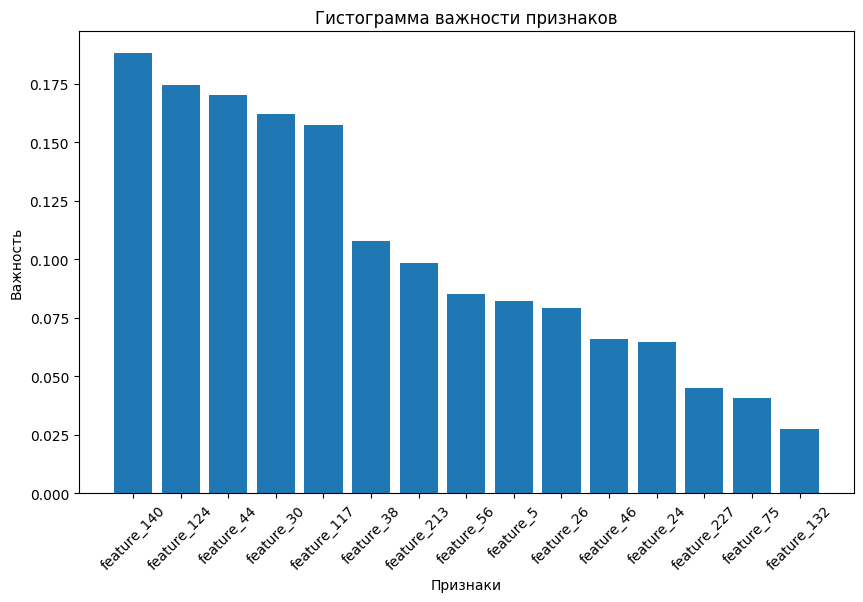

In [ ]:
#Гистограмма, показывающая важность признаков на основе коэфициентов лог рега
coef = logreg.coef_[0]

# Создание датафрейма с важностью признаков
feature_importance = pd.DataFrame(abs(coef), top15features_stable+features_top_IV_stable, columns=['importance'])

# Сортировка признаков по важности
feature_importance = feature_importance.sort_values(by='importance', ascending=False)

# Построение гистограммы
plt.figure(figsize=(10, 6))
plt.bar(feature_importance.index, feature_importance['importance'])
plt.xlabel('Признаки')
plt.ylabel('Важность')
plt.title('Гистограмма важности признаков')
plt.xticks(rotation=45)
plt.show()

# Бонусная часть (3 балла)

В разделе про бустинг мы обучали `LGBMClassifier` на довольно большом наборе фичей. Их количество можно сократить, при этом не теряя в качестве модели.

За начальный набор признаков можно взять все признаки (все 230) или признаки после отбора по IV.

**Ваша задача:** Отобрать признаки, подобрать оптимальные гиперпараметры и обучить `LGBMClassifier`.

Задание творческое) Можно использовать любые методы отбора признаков / оптимизации гиперпараметров.

**Чем меньше признаков, без ухудшения качества модели – тем лучше.**

In [ ]:
# your code here

Идеи для отбора признаков:

- Воспользоваться методами из модуля `sklearn.feature_selection` (точно можно попробовать RFE). Документация https://scikit-learn.org/stable/modules/feature_selection.html
- С помощью `BorutaPy` из библиотеки `boruta` (https://towardsdatascience.com/simple-example-using-boruta-feature-selection-in-python-8b96925d5d7a – статья может помочь разобраться с запуском алгоритма (мб не откроется без vpn))

In [ ]:
# your answere here